## Linear Regression using TensorFlow

* This notebook is adapted from [Aymeric Damian's notebook](https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/2_BasicModels/linear_regression.ipynb) 

* Clone the full collection [here](https://github.com/aymericdamien/TensorFlow-Examples).

## What is a Tensor?

A [Tensor](https://en.wikipedia.org/wiki/Tensor) in mathematics is an object that specifies a linear relationship.

In **Tensorflow** the term Tensor corresponds to a $k$ dimensional arrays of numbers. Specifically:   
1. A $0$-dimensional tensor is a Scalar.
2. A $1$-dimensional tensor is a Vector, or a $1$-dimensional numpy array.
3. A $2$ dimensional tensor is a Matrix.
4. A $k$ dimensional tensor is a $k$ dimensional numpy array.

Tensors are the main data type in TensorFlow. In other words, most variables in TensorFlow are numpy arrays.

## What is Linear Regression?

We are assuming that this is not the first time you are using Linear, if it isnt, 
we recommend you review: [linear regression review in dataschool.io](http://www.dataschool.io/linear-regression-in-python/)

Linear regression attempts to model the relationship between two variables by fitting a linear equation to observed data. One variable is considered to be an explanatory variable, and the others are considered to be dependent variables. For our example, we want to relate the variable Y to the variable X using a linear regression model. 

## A linear model

$\hat{y}$ is a linear function of the vector $\vec{x}=(x_1,\ldots,x_p)$ if:  
$\hat{y} = b + w_1 x_1 + \ldots+w_p x_p$  
Where:  
* $\hat{y}$ is the estimate of the true output $y$.
* $\vec{w} = (w_1,\ldots,v_p)$ are the weights
* $b$ is the bias term
* $\vec{x}=(x_1,\ldots,x_p)$ is the feature vector

More succinctly:  $ \hat{y}= b + \vec{w} \cdot \vec{x}$

### Some toy data

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
rng = np.random
logs_path = 'logs/lesson1'

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
train_X = np.asarray([3.3,4.4,5.5,6.71,6.93,4.168,9.779,6.182,7.59,2.167,
                         7.042,10.791,5.313,7.997,5.654,9.27,3.1])
train_Y = np.asarray([1.7,2.76,2.09,3.19,1.694,1.573,3.366,2.596,2.53,1.221,
                         2.827,3.465,1.65,2.904,2.42,2.94,1.3])
n_samples = train_X.shape[0]

## Tensorflow representation of a Linear Regression Model

TensorFlow concepts:

|  Tensorflow  | common term | Description |
| --- | --- | ---|
| placeholder | input ports | Associated with an input stream |
| variable    | Variables | Maintained between input examples and between epochs |
| name_scope  | subroutine name-spaces | Used to encapsulate the functions of a **node** 
| Session     | Run-time environment | Used to execute the computation graph on training data |

### [Placeholders](https://www.tensorflow.org/api_guides/python/io_ops#Placeholders) 
Define entry points for training data. Similar to *ports* in computer systems.

In [3]:
# Input to the graph
y = tf.placeholder(dtype = tf.float32, name = 'InputData') # Placeholders - https://www.tensorflow.org/api_guides/python/io_ops#Placeholders
x = tf.placeholder(dtype = tf.float32, name = 'LabelData')

### [Variables](https://www.tensorflow.org/programmers_guide/variables)
Similar to variables in a programming language such as python.

In [4]:
# Model parameters are defined using variables
# Variables retain their value even outside the bounds of a session's run call
w = tf.Variable(initial_value = rng.randn(), name = "weight") 
b = tf.Variable(initial_value = rng.randn(), name = "bias")

### name_scope
Defines a name-space which is used by a function. and defines a node in the TensorFlow graph.

In [5]:
# Connecting up the nodes in our linear model
# y = b + Wx
with tf.name_scope('model'):
    prediction = tf.add(b, tf.multiply(w, x))

# prediction holds the tensor that is the output of the operation add which takes tensors b, and the output of the multiply operation between the weight w, and the input x

## Learning the Regression parameters

Now that we have the linear model, we need to define the **Loss** and the **Optimizer** that will learn the parameters `w,b` from training data.

### Defining the average loss
We define the loss to be the average of the square errors.
$$\mbox{loss} = \frac{\sum_{i=1}^n (\hat{y} - y)^2}{n}$$

In [6]:
with tf.name_scope('Loss'):
    loss = tf.reduce_sum( input_tensor = tf.pow(prediction-y, 2))/(2*n_samples)

In [7]:
## The purpose of the following two commands is to log the activity 
tf.summary.scalar("loss", loss)
merged_summary_op = tf.summary.merge_all()

### Defining the optimizer
Our goal is to find the settings of `w,b` that minimize the average loss. **Tensorflow** has a number of [powerful optimizers built-in](https://www.tensorflow.org/api_guides/python/train#Optimizers). Here we are using one of the implest ones: Stochastic Gradient Descent(SGD).

In [8]:
learning_rate = 0.01
with tf.name_scope('SGD'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [9]:
# We also need an operation to initialize our global variables (w and b)
init = tf.global_variables_initializer()

## The computational graph

### Hand-drawn
(Using [LucidChart](https://www.lucidchart.com/))
<center><img src="img/LinearRegression_lucidchart.png" alt="An example image of an ML model visualized using TensorBoard" style="width:800px;"></center>

### Automatically generated
([TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard) automatically generates a graph and an interactive GUI from Tensorflow code).

<center><img src="img/LinearRegression.png" alt="An example image of an ML model visualized using TensorBoard" style="width:800px;"></center>

## Executing the Computational Graph in a session
The computational graph defines the computation that is to be done, but it does not execute anything. (If you are interested in immediate execution, you might want to use the [Eager API](https://www.tensorflow.org/programmers_guide/eager))

* Using the classical API, the computational graph is executed inside a **session**

* A typical session is divided into **epochs**, each epoch corresponds to a single pass over the training data.

* The training set is divided into **training samples**. 
  * A parallelization opportunity: each training sample can reside on a different computer.

## Session code walkthrough

* Initializing a few parameters.
``` python
training_epochs = 1000              # We will run our optimizer for 1000 epochs
display_step = 100                  # Display the loss every 100 runs
final_w, final_b = 0,0
```

* Initialize Session
```python
with tf.Session() as sess:
    sess.run(init)  # initialize variables
    # Initialize logging
    summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
```

* The main method for a session is `session.run` which recieves as input:
   * The graph nodes that must be executed (other nodes will be run to provide needed inputs)
   * The datasets that are to be used as input (throught the placeholders).

* The main part of the code
```python
    # Fit all training data
    for epoch in range(training_epochs):
        for (sample_x, sample_y) in zip(train_X, train_Y):
            sess.run(optimizer, feed_dict={x: sample_x, y: sample_y})
```

```python
        #Display logs per epoch step
        if (epoch+1) % display_step == 0:
            c , summary= sess.run([loss, merged_summary_op], feed_dict={x: train_X, y:train_Y})
            summary_writer.add_summary(summary, epoch)
            print("Epoch:", '%04d' % (epoch+1), "loss=", "{:.9f}".format(c), \
                "w=", sess.run(w), "b=", sess.run(b))
```

* Wrapping up: recompute training error at the end, and capture final parameters.

```python
    print("Optimization Finished!")
    training_loss = sess.run(loss, feed_dict={x: train_X, y:train_Y})
    print("Training loss=", training_loss, "w=", sess.run(w), "b=", sess.run(b), '\n')
    final_w, final_b = sess.run(w), sess.run(b)
```

In [10]:
# We can now run the computational graph in a session
training_epochs = 1000              # We will run our optimizer for 1000 epochs
display_step = 100                  # Display the loss every 100 runs
final_w, final_b = 0,0
with tf.Session() as sess:
    sess.run(init)
    summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

    # Fit all training data
    for epoch in range(training_epochs):
        for (sample_x, sample_y) in zip(train_X, train_Y):
            sess.run(optimizer, feed_dict={x: sample_x, y: sample_y})

        #Display logs per epoch step
        if (epoch+1) % display_step == 0:
            c , summary= sess.run([loss, merged_summary_op], feed_dict={x: train_X, y:train_Y})
            summary_writer.add_summary(summary, epoch)
            print("Epoch:", '%04d' % (epoch+1), "loss=", "{:.9f}".format(c), \
                "w=", sess.run(w), "b=", sess.run(b))

    print("Optimization Finished!")
    training_loss = sess.run(loss, feed_dict={x: train_X, y:train_Y})
    print("Training loss=", training_loss, "w=", sess.run(w), "b=", sess.run(b), '\n')
    final_w, final_b = sess.run(w), sess.run(b)

Epoch: 0100 loss= 0.146125212 w= 0.39666408 b= -0.2565482
Epoch: 0200 loss= 0.131065816 w= 0.37969038 b= -0.1344404
Epoch: 0300 loss= 0.119284406 w= 0.3646756 b= -0.026425347
Epoch: 0400 loss= 0.110067815 w= 0.35139373 b= 0.069123514
Epoch: 0500 loss= 0.102857880 w= 0.33964473 b= 0.153645
Epoch: 0600 loss= 0.097217947 w= 0.3292518 b= 0.22841167
Epoch: 0700 loss= 0.092806287 w= 0.32005808 b= 0.29454947
Epoch: 0800 loss= 0.089355603 w= 0.3119256 b= 0.3530542
Epoch: 0900 loss= 0.086656652 w= 0.30473164 b= 0.40480733
Epoch: 1000 loss= 0.084545895 w= 0.2983681 b= 0.45058644
Optimization Finished!
Training loss= 0.084545895 w= 0.2983681 b= 0.45058644 



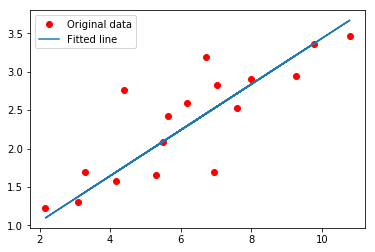

In [11]:
#Graphic display
plt.plot(train_X, train_Y, 'ro', label='Original data')
plt.plot(train_X, final_w * train_X + final_b, label='Fitted line')
plt.legend()
plt.show()

## The three ingredients of learning NN.
There are three ingredients to learning NN:
1. **The model architecture:** defines how the the output prediction $\hat{y}$ is computed from the input $X$ and the parameters $W$.
1. **The Loss function:** quantifies the difference between the output $y$ and the prediction $\hat{y}$.
1. **The optimizer:** finds a parameter setting $W^*$ that minimizes the average loss

## The parts of a basic Tensorflow program
### Basic units:
1. **the inputs:** defined as `placeholder`s
2. **The weights:** defined as `variable`s

### Nodes in the computation graph:
3. **The model** 
4. **The loss function** 
5. **The optimizer** 

### The session
Defines the order in which the elements of the computation graph are computed.